#### import packages

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive"
os.chdir(path)
!ls

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#install and import dependency packages
#!pip3 install vncorenlp
!pip3 install transformers
!pip3 install datasets

     |████████████████████████████████| 3.4 MB 28.1 MB/s 
     |████████████████████████████████| 3.3 MB 62.7 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 63.9 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 311 kB 31.1 MB/s 
     |████████████████████████████████| 133 kB 74.7 MB/s 
     |████████████████████████████████| 1.1 MB 67.0 MB/s 
     |████████████████████████████████| 243 kB 78.4 MB/s 
     |████████████████████████████████| 144 kB 75.3 MB/s 
     |████████████████████████████████| 271 kB 75.6 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from tqdm import tqdm
import pickle
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
from sklearn.metrics import accuracy_score
import os
from transformers import RobertaForSequenceClassification, AdamW, RobertaModel, AutoTokenizer
from datetime import datetime
import pandas as pd
from torch import nn

In [ ]:
#download PhoBERT_base
#!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
#!tar -xzvf PhoBERT_base_transformers.tar.gz

In [4]:
!ls PhoBERT_base_transformers

bpe.codes  config.json	dict.txt  model.bin  vocab.txt


### Các hàm phụ 

In [40]:
### Load raw data
def read_txt(path):
  with open(path,'r',encoding='utf-8') as f:
    dt = f.read().split('\n')
  return dt

def load_data():
  f_data=[]
  dir = os.path.join('/content/gdrive/MyDrive/BERT/PhoATIS','')
  name = ['train_in.txt','train_label.txt','val_in.txt','val_label.txt','test_in.txt','test_label.txt','intent_label.txt']
  for n in name:
    path = os.path.join(dir, n)
    f_data.append(read_txt(path))
  return f_data

### Hàm lưu và load data đã tiền xử lý
def _save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

# Lưu và load checkpoint model  
def load_checkpoint(path):
    if path is None:
        return
    stats_dict = torch.load(path, map_location = device)
    return stats_dict

def save_checkpoint(path):
        state_dict = {'model_state_dict': model.state_dict()}
        torch.save(state_dict, path)

# Hàm đánh giá độ chính xác
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis =1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(pred_flat ,labels_flat)

### loại bỏ các class xuất hiện rất ít 

In [ ]:
"Dữ liệu gốc có 5871 câu."
# df_train = pd.DataFrame({'text':train_in,'intent':train_label}, columns=['text', 'intent'])
# df_val = pd.DataFrame({'text':val_in,'intent':val_label},columns=['text', 'intent'])
# df_test = pd.DataFrame({'text':test_in,'intent':test_label},columns=['text', 'intent'])
# data = df_train.append(df_val).sample(frac=1).reset_index(drop=True)
# df = data.append(df_test).sample(frac=1).reset_index(drop=True)
# print('\n data: ',len(df),'\n')


 data:  5871 



In [8]:
"Bỏ các class rất ít xuất hiện trong tập dữ liệu, cụ thể là các class có tần suất xuất hiện < 13":

('airline#flight_no','day_name','airfare#flight_time','aircraft#flight#flight_no','aircraft#flight','flight#flight_no',
 'flight#flight_time','airline#flight','flight_no#flight_time','ground_fare#ground_service', 'city#flight_time')

# train_in, train_label ,val_in, val_label, test_in, test_label ,intent = load_data()
# print("Train: ", len(train_label))
# print("\nValidation: ", len(val_label))
# print("\nTest: ",len(test_label))
# print("\nNum of intent: ", len(intent))

# drop = ('airline#flight_no','day_name','airfare#flight_time','aircraft#flight#flight_no','aircraft#flight','flight#flight_no','flight#flight_time','airline#flight','flight_no#flight_time','ground_fare#ground_service', 'city#flight_time')
# for i,r in df.iterrows():
#     for name in drop:
#         if r.intent==name:
#             df=df.drop(index = i)

# _save_pkl("clean_data.pkl", df)

In [9]:
df = _load_pkl("clean_data.pkl")
intents = df.intent.unique()

In [49]:
"Tập dữ liệu còn lại gồm 5854 câu, gồm 17 intent"
df
intents
len(intents)

'Tập dữ liệu còn lại gồm 5854 câu, gồm 17 intent'

,text,intent
0,các chuyến bay từ thành_phố hồ_chí_minh ngày m...,flight
1,liệt_kê cho tôi các chuyến bay từ vinh đến điệ...,flight
2,tôi muốn biết thông_tin về vé máy_bay khứ_hồi ...,airfare
3,sức chứa của máy_bay boeing 787 là bao_nhiêu,capacity
4,liệt_kê giúp tôi các chuyến bay từ bordeaux đế...,flight
...,...,...
5866,liệt_kê cho tôi các chuyến bay aeroflot vào th...,flight
5867,tôi muốn đi chuyến bay từ washingtion dc tạm d...,flight
5868,hiển_thị chuyến bay đầu_tiên từ vinh đến đà_lạt,flight
5869,tôi muốn một chiếc limo ở torino vào ngày mồng...,ground_service


array(['flight', 'airfare', 'capacity', 'ground_service', 'abbreviation',
       'flight_time', 'airline', 'airfare#flight', 'airport', 'distance',
       'ground_fare', 'aircraft', 'quantity', 'meal', 'restriction',
       'city', 'flight_no'], dtype=object)

17

In [11]:
#Chia tập train, valid, test
# split train dataset into train, validation and test sets
from sklearn.model_selection import train_test_split

train_in, temp_text, train_label, temp_labels = train_test_split(df['text'], df['intent'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['intent'])


val_in, test_in, val_label, test_label = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [12]:
df_train = pd.DataFrame({'text':train_in,'intent':train_label}, columns=['text', 'intent'])
df_val = pd.DataFrame({'text':val_in,'intent':val_label},columns=['text', 'intent'])
df_test = pd.DataFrame({'text':test_in,'intent':test_label},columns=['text', 'intent'])


### Visualization data

In [13]:
#Visualization 
#inport package
import random
import time
import numpy as np
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1)
rcParams['figure.figsize'] = 15,8
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)

In [14]:
## Function to visualize Data
def viz_set(set_X, set_Y, set_name):
    df = pd.DataFrame({'text':set_X,'intent':set_Y})
    chart = sns.countplot(df.intent)
    title = str(set_name) + "fold: Number of texts per intent"
    plt.title(title)
    chart.set_yscale('log')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


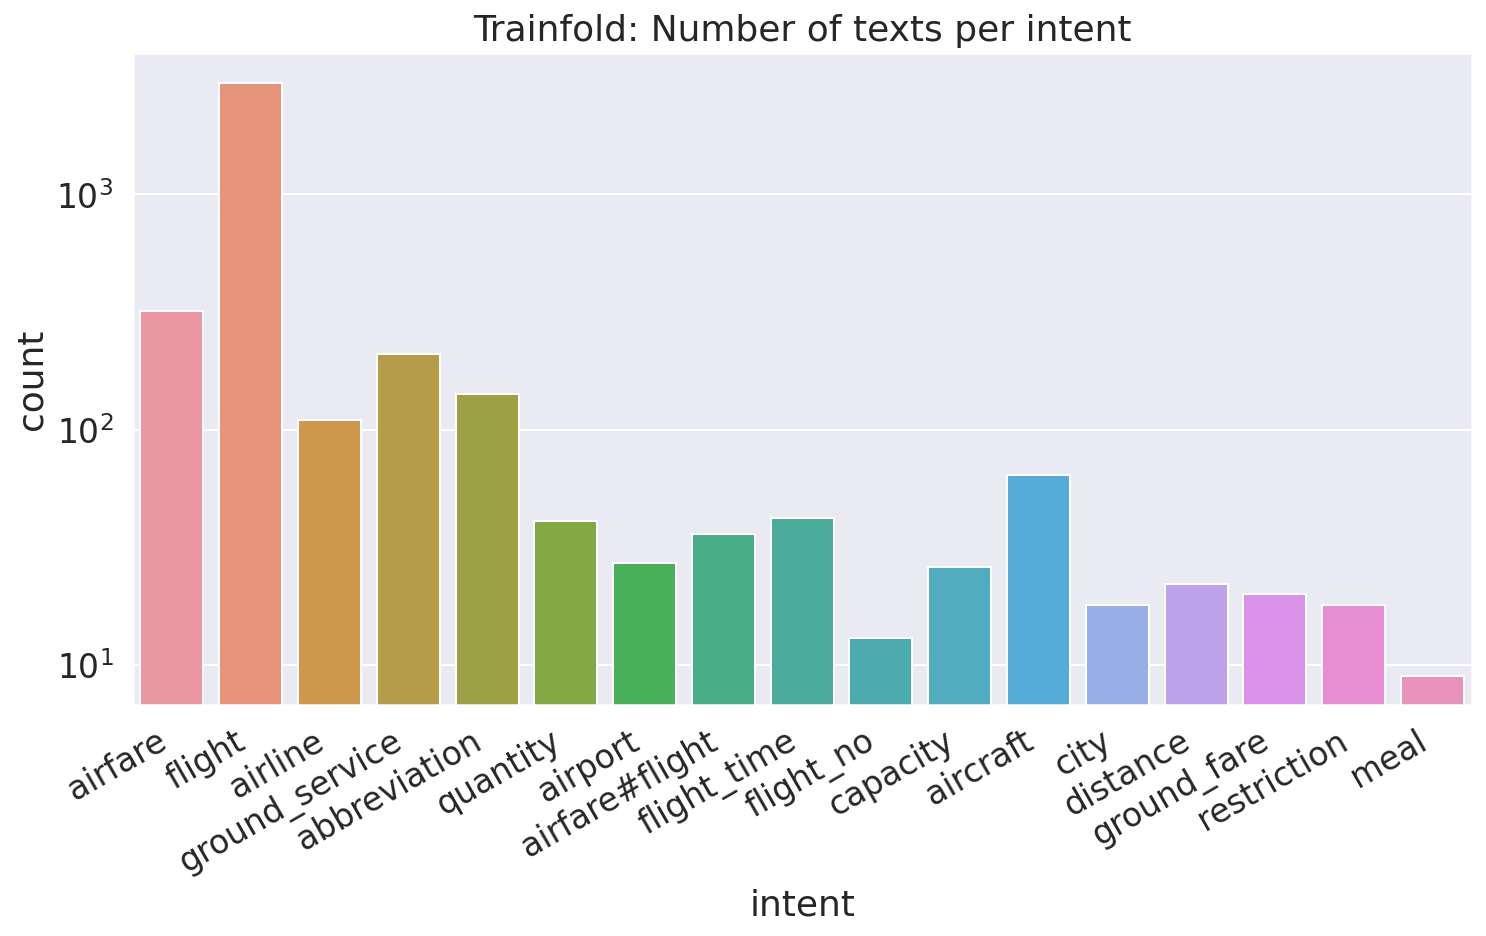

In [50]:
#Visualize data of train fold
viz_set(train_in, train_label, 'Train')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


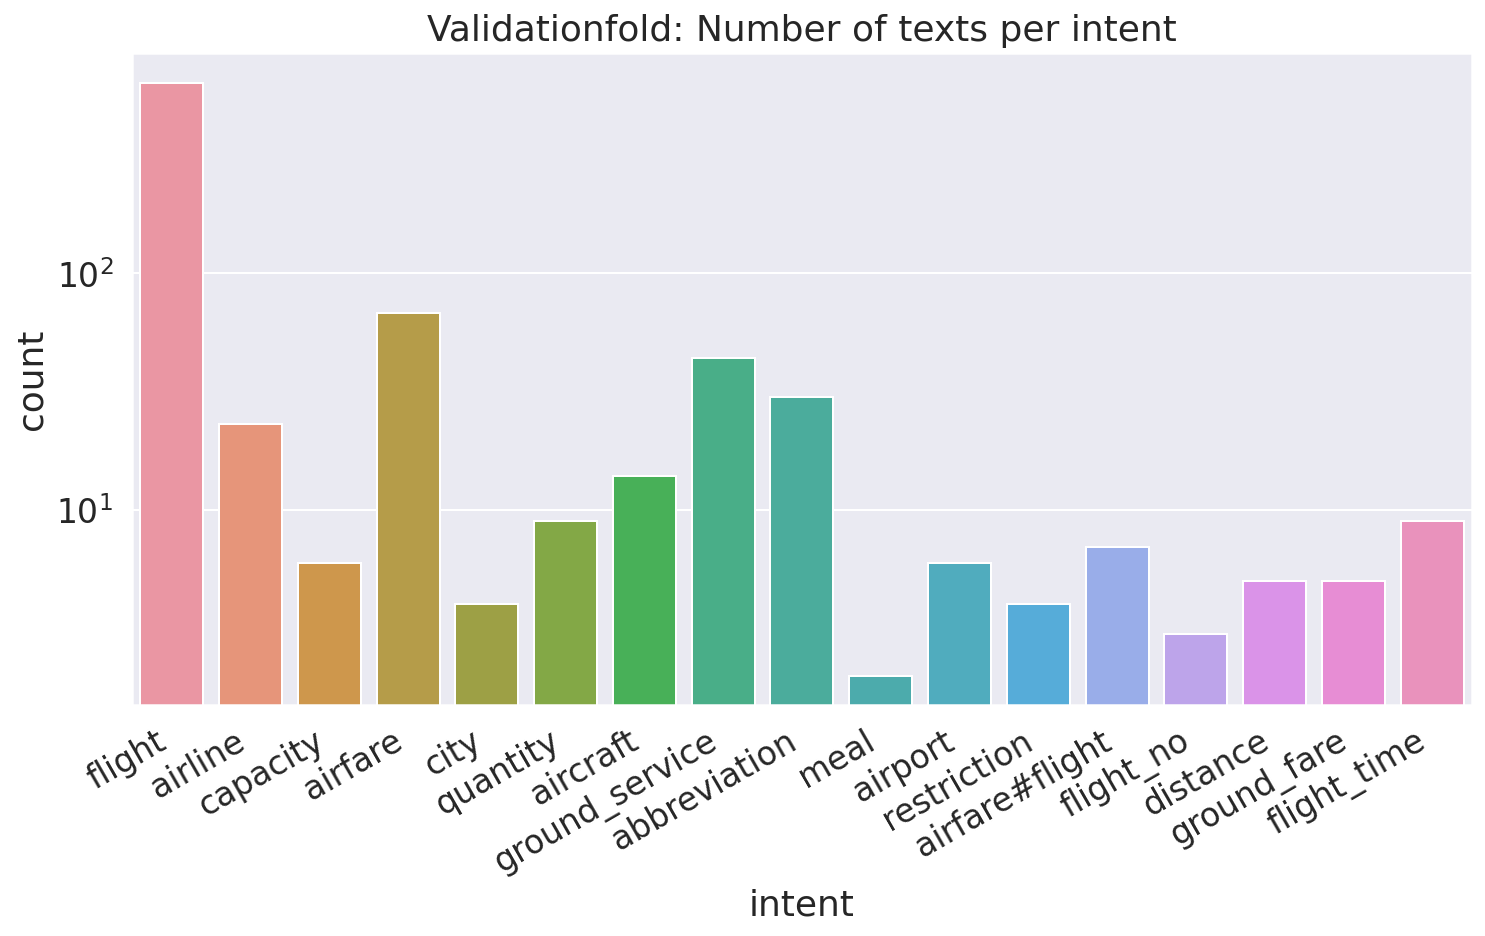

In [51]:
#Visualize data of validation fold
viz_set(val_in, val_label, 'Validation')

### Tiền xử lý

In [15]:
#Tiền xử lý dữ liệu
def preprpcess(sents, segment = False, max_len = 256, fold = 'train'):
    ids_pad, at_masks= [], []
    texts = []
    
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

    #segment
    for text in sents:
        if segment:
            rsegment = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
            text = rsegmenter.tokenize(text.strip())
            text = ' '.join([' '.join(x) for x in text])
        texts.append(text)

    #text to ids and padding
    # ids
    ids = []
    for text in tqdm(texts):
            enc_text = tokenizer.encode(text)
            ids.append(enc_text)

    del texts
    # padding
    ids_pad = pad_sequences(ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")
    del ids

    #attention mask
    for id in ids_pad:
        mask = [int(token_id > 0) for token_id in id]
        at_masks.append(np.array(mask))

    # save data
    name = str(fold)+".pkl"
    _save_pkl("ids_"+name, ids_pad)
    _save_pkl("masks_"+name, at_masks)

    return ids_pad, at_masks

#label encode
def encode_label(raw_classes, intents):
    label= LabelEncoder()
    label = label.fit(intents)
    label = label.fit_transform(raw_classes)
    return label

#Tạo dataset và dataloader cho quá trình học
def prepair(ids_pad, at_masks, labels, batch_size=16):
    #convert sang torch tensor
    ids_pad = torch.tensor(ids_pad)
    at_masks = torch.tensor(at_masks)
    labels = torch.tensor(labels)
    #dataset
    input_data = TensorDataset(ids_pad, at_masks, labels)
    #dataloader
    data_loader = DataLoader(input_data, sampler=SequentialSampler(input_data), batch_size = batch_size)

    return data_loader

### Fine tuning model Phobert

In [16]:
# Phobert CLassification model

class PHObertClassifier(torch.nn.Module):
    def __init__(self, list_intents, class_weights):
        super(PHObertClassifier, self).__init__()
        self.num_labels = len(list_intents)
        self.config = RobertaConfig.from_pretrained("PhoBERT_base_transformers/config.json",
                                               from_tf = False,
                                               num_labels= self.num_labels,
                                               output_hidden_states = False,
                                               )
        self.phobert =  RobertaForSequenceClassification.from_pretrained(
                                    "PhoBERT_base_transformers/model.bin",
                                        config = self.config
                                        )
        
        #self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        #self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)
        self.weight = class_weights

    def forward(self, input_ids, attention_mask, labels,return_dict=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.phobert(
                                input_ids=input_ids,
                                token_type_ids=None,
                                attention_mask=attention_mask,
                                labels=labels
                                )
    
        pooled_output = outputs[1]

        #pooled_output = self.dropout(pooled_output)
        logits = pooled_output

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=self.weight)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        outputs = (loss,) + ((logits,) + outputs[2:])
        return outputs

### Thực hiện training

In [17]:
from sklearn.utils.class_weight import compute_class_weight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#tính classes weigth
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = train_label.unique(),
                                        y = train_label                                        
                                    )
weights= torch.tensor(weights,dtype=torch.float)
# push to GPU
weights = weights.to(device)

In [18]:
weights

tensor([ 0.7531,  0.0808,  2.1909,  1.1531,  1.7092,  5.8780,  8.9259,  6.6944,
         5.7381, 18.5385,  9.2692,  3.7656, 13.3889, 10.9545, 12.0500, 13.3889,
        26.7778], device='cuda:0')

Tạo dataloader cho mô hình

In [20]:
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

ids_train , atms_train = preprpcess(train_in, max_len = 32, fold="train")
ids_valid , atms_valid =  preprpcess(val_in, max_len = 32, fold="valid")

labels_train = encode_label(train_label, intents)
labels_valid = encode_label(val_label, intents)

train_loader = prepair(ids_train, atms_train, labels_train)
valid_loader = prepair(ids_valid, atms_valid, labels_valid)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 4097/4097 [00:00<00:00, 6609.64it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 878/878 [00:00<00:00, 6207.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Khởi tạo mô hình

In [19]:
model = PHObertClassifier(intents, weights)
model.eval()

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

Huấn luyện mô hình

In [26]:
torch.cuda.empty_cache()

model.to(device)
#train_loader
#valid_loader
epochs = 5

# khởi tạo các tham số
# Khởi tạo optimizer và scheduler

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.01,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

training_stats = []

for epoch in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('\nTraining...')

    total_loss = 0
    train_acc = 0
    train_steps = 0

    best_valid_loss = float('inf')
    best_eval_acc = 0

    model.train()
    for step, batch in enumerate(train_loader):

        input = {
                    "input_ids" : batch[0].to(device),
                    "attention_mask" :batch[1].to(device),
                    "labels" : batch[2].to(device)
                    }
        
        model.zero_grad() #clear calculated gradients before
        outputs = model(**input)
        
        loss, logits = outputs[0], outputs[1]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = input['labels'].cpu().numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_acc += tmp_train_accuracy
        
        train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if step % 100 == 0:
            print("\n[TRAIN] Epoch {}/{} | Batch {}/{} | Train Loss={}".format(epoch, epochs, step, len(train_loader), loss.item()))
        
    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = train_acc/train_steps
    print(" \nTrain Accuracy: {0:.4f}".format(train_acc/train_steps))
    print(" \nTrain Loss: {0:.4f}".format(avg_train_loss))

    print("\nRunning Validation...")
    model.eval()
    eval_loss = 0
    eval_acc = 0
    eval_steps = 0

    for step, batch in enumerate(valid_loader):
        input = {
                    "input_ids" : batch[0].to(device),
                    "attention_mask" :batch[1].to(device),
                    "labels" : batch[2].to(device)
                    }
        
        with torch.no_grad():
            outputs = model(**input)
        
            tmp_eval_loss = outputs[0]
            eval_loss += tmp_eval_loss.item()
        
            logits = outputs[1].detach().cpu().numpy()
            label_ids = input['labels'].cpu().numpy()
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_acc += tmp_eval_accuracy
            eval_steps += 1

    avg_valid_loss = eval_loss/eval_steps
    avg_eval_acc  = eval_acc/eval_steps
    print(" Valid Loss: {0:.4f}".format(avg_valid_loss))
    print(" Valid Accuracy: {0:.4f}".format(avg_eval_acc))

    if best_valid_loss > eval_loss:
        best_valid_loss = eval_loss
        best_valid_loss_path = "{}/model_best.pt".format("/content/gdrive/MyDrive")
        save_checkpoint(best_valid_loss_path)

    
    training_stats.append(
            {
                'epoch': epoch,
                'training_loss': avg_train_loss,
                'valid_loss': avg_valid_loss,
                'training_acc': avg_train_acc,
                'valid_acc': avg_eval_acc,
                'train_steps': train_steps,
                'eval_steps': eval_steps
            })
    
print("Training complete!")


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li


======== Epoch 1 / 5 ========
Training...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

tensor(0.0315, device='cuda:0')

[TRAIN] Epoch 0/5 | Batch 0/257 | Train Loss=0.00330642843618989


tensor(0.3314, device='cuda:0')

tensor(0.1749, device='cuda:0')

tensor(1.2476, device='cuda:0')

tensor(1.1502, device='cuda:0')

tensor(0.4818, device='cuda:0')

tensor(0.1015, device='cuda:0')

tensor(0.0163, device='cuda:0')

tensor(0.0315, device='cuda:0')

tensor(2.3222, device='cuda:0')

tensor(1.6760, device='cuda:0')

tensor(0.1356, device='cuda:0')

tensor(1.2656, device='cuda:0')

tensor(0.1940, device='cuda:0')

tensor(0.1399, device='cuda:0')

tensor(0.2064, device='cuda:0')

tensor(5.5654, device='cuda:0')

tensor(0.0721, device='cuda:0')

tensor(0.3424, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0604, device='cuda:0')

tensor(0.0118, device='cuda:0')

tensor(2.9908, device='cuda:0')

tensor(2.3221, device='cuda:0')

tensor(0.6257, device='cuda:0')

tensor(5.0327, device='cuda:0')

tensor(0.3074, device='cuda:0')

tensor(1.9438, device='cuda:0')

tensor(0.8599, device='cuda:0')

tensor(0.2723, device='cuda:0')

tensor(0.4478, device='cuda:0')

tensor(0.1617, device='cuda:0')

tensor(0.3669, device='cuda:0')

tensor(0.2362, device='cuda:0')

tensor(0.1678, device='cuda:0')

tensor(0.2706, device='cuda:0')

tensor(0.1705, device='cuda:0')

tensor(0.3165, device='cuda:0')

tensor(2.2536, device='cuda:0')

tensor(0.2631, device='cuda:0')

tensor(0.2151, device='cuda:0')

tensor(0.1313, device='cuda:0')

tensor(31.6583, device='cuda:0')

tensor(0.0237, device='cuda:0')

tensor(0.0532, device='cuda:0')

tensor(0.1758, device='cuda:0')

tensor(7.8577, device='cuda:0')

tensor(0.0708, device='cuda:0')

tensor(0.7766, device='cuda:0')

tensor(0.0249, device='cuda:0')

tensor(11.2714, device='cuda:0')

tensor(0.1339, device='cuda:0')

tensor(0.1624, device='cuda:0')

tensor(0.1815, device='cuda:0')

tensor(0.4991, device='cuda:0')

tensor(2.3561, device='cuda:0')

tensor(15.0992, device='cuda:0')

tensor(0.0926, device='cuda:0')

tensor(0.0747, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.2829, device='cuda:0')

tensor(1.9877, device='cuda:0')

tensor(0.1868, device='cuda:0')

tensor(0.3927, device='cuda:0')

tensor(1.6482, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.1208, device='cuda:0')

tensor(0.2861, device='cuda:0')

tensor(0.0700, device='cuda:0')

tensor(0.0312, device='cuda:0')

tensor(0.2272, device='cuda:0')

tensor(0.4302, device='cuda:0')

tensor(7.5785, device='cuda:0')

tensor(0.0671, device='cuda:0')

tensor(0.0571, device='cuda:0')

tensor(0.7473, device='cuda:0')

tensor(0.8445, device='cuda:0')

tensor(0.0480, device='cuda:0')

tensor(0.3368, device='cuda:0')

tensor(0.0855, device='cuda:0')

tensor(8.0560, device='cuda:0')

tensor(0.0921, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.1080, device='cuda:0')

tensor(0.1120, device='cuda:0')

tensor(0.0409, device='cuda:0')

tensor(0.0880, device='cuda:0')

tensor(16.6815, device='cuda:0')

tensor(0.0616, device='cuda:0')

tensor(1.4093, device='cuda:0')

tensor(0.0410, device='cuda:0')

tensor(0.2234, device='cuda:0')

tensor(0.0681, device='cuda:0')

tensor(3.6994, device='cuda:0')

tensor(0.1072, device='cuda:0')

tensor(0.0398, device='cuda:0')

tensor(0.0129, device='cuda:0')

tensor(1.7032, device='cuda:0')

tensor(0.1151, device='cuda:0')

tensor(20.6880, device='cuda:0')

tensor(3.3124, device='cuda:0')

[TRAIN] Epoch 0/5 | Batch 100/257 | Train Loss=0.06893888860940933


tensor(0.0335, device='cuda:0')

tensor(0.1959, device='cuda:0')

tensor(0.2305, device='cuda:0')

tensor(0.1244, device='cuda:0')

tensor(6.7441, device='cuda:0')

tensor(0.0668, device='cuda:0')

tensor(0.1681, device='cuda:0')

tensor(0.0225, device='cuda:0')

tensor(0.0986, device='cuda:0')

tensor(13.5289, device='cuda:0')

tensor(0.9510, device='cuda:0')

tensor(0.1666, device='cuda:0')

tensor(2.5426, device='cuda:0')

tensor(0.6742, device='cuda:0')

tensor(0.0809, device='cuda:0')

tensor(0.1051, device='cuda:0')

tensor(0.2180, device='cuda:0')

tensor(0.5303, device='cuda:0')

tensor(0.0621, device='cuda:0')

tensor(0.0157, device='cuda:0')

tensor(0.2877, device='cuda:0')

tensor(1.0696, device='cuda:0')

tensor(0.0242, device='cuda:0')

tensor(0.0587, device='cuda:0')

tensor(0.0244, device='cuda:0')

tensor(0.0461, device='cuda:0')

tensor(0.3103, device='cuda:0')

tensor(0.0347, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.0182, device='cuda:0')

tensor(0.0734, device='cuda:0')

tensor(0.0942, device='cuda:0')

tensor(0.6802, device='cuda:0')

tensor(0.0212, device='cuda:0')

tensor(0.4207, device='cuda:0')

tensor(0.1470, device='cuda:0')

tensor(0.2112, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(0.0314, device='cuda:0')

tensor(0.0572, device='cuda:0')

tensor(0.2234, device='cuda:0')

tensor(6.1711, device='cuda:0')

tensor(1.9535, device='cuda:0')

tensor(0.1277, device='cuda:0')

tensor(0.0287, device='cuda:0')

tensor(0.0721, device='cuda:0')

tensor(0.4923, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0117, device='cuda:0')

tensor(1.2946, device='cuda:0')

tensor(0.4875, device='cuda:0')

tensor(0.1181, device='cuda:0')

tensor(0.1853, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.2071, device='cuda:0')

tensor(0.0550, device='cuda:0')

tensor(34.1764, device='cuda:0')

tensor(0.9982, device='cuda:0')

tensor(1.9250, device='cuda:0')

tensor(0.0105, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0172, device='cuda:0')

tensor(0.7044, device='cuda:0')

tensor(0.0481, device='cuda:0')

tensor(0.0627, device='cuda:0')

tensor(0.3875, device='cuda:0')

tensor(0.1563, device='cuda:0')

tensor(0.0208, device='cuda:0')

tensor(0.0121, device='cuda:0')

tensor(1.3750, device='cuda:0')

tensor(0.0579, device='cuda:0')

tensor(0.3919, device='cuda:0')

tensor(0.0873, device='cuda:0')

tensor(4.3608, device='cuda:0')

tensor(4.6604, device='cuda:0')

tensor(0.1424, device='cuda:0')

tensor(10.5340, device='cuda:0')

tensor(0.0397, device='cuda:0')

tensor(6.3404, device='cuda:0')

tensor(0.0548, device='cuda:0')

tensor(2.6541, device='cuda:0')

tensor(0.1692, device='cuda:0')

tensor(0.1666, device='cuda:0')

tensor(0.0305, device='cuda:0')

tensor(4.6039, device='cuda:0')

tensor(3.4202, device='cuda:0')

tensor(1.6014, device='cuda:0')

tensor(0.1465, device='cuda:0')

tensor(0.4163, device='cuda:0')

tensor(0.3177, device='cuda:0')

tensor(0.0194, device='cuda:0')

tensor(32.0253, device='cuda:0')

tensor(0.1509, device='cuda:0')

tensor(0.1306, device='cuda:0')

tensor(0.3144, device='cuda:0')

tensor(0.0600, device='cuda:0')

tensor(0.0171, device='cuda:0')

tensor(0.0794, device='cuda:0')

tensor(5.5894, device='cuda:0')

tensor(3.0905, device='cuda:0')

[TRAIN] Epoch 0/5 | Batch 200/257 | Train Loss=0.009012953378260136


tensor(0.8665, device='cuda:0')

tensor(0.1617, device='cuda:0')

tensor(3.6211, device='cuda:0')

tensor(1.6349, device='cuda:0')

tensor(10.9094, device='cuda:0')

tensor(0.0745, device='cuda:0')

tensor(0.8521, device='cuda:0')

tensor(0.2195, device='cuda:0')

tensor(1.3156, device='cuda:0')

tensor(0.1238, device='cuda:0')

tensor(0.1639, device='cuda:0')

tensor(0.0931, device='cuda:0')

tensor(4.0686, device='cuda:0')

tensor(0.0505, device='cuda:0')

tensor(1.5045, device='cuda:0')

tensor(0.0603, device='cuda:0')

tensor(0.0351, device='cuda:0')

tensor(0.2794, device='cuda:0')

tensor(0.0203, device='cuda:0')

tensor(22.5502, device='cuda:0')

tensor(0.0684, device='cuda:0')

tensor(0.1068, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.1982, device='cuda:0')

tensor(0.1094, device='cuda:0')

tensor(0.0828, device='cuda:0')

tensor(0.1312, device='cuda:0')

tensor(0.2038, device='cuda:0')

tensor(0.0176, device='cuda:0')

tensor(0.1335, device='cuda:0')

tensor(2.2817, device='cuda:0')

tensor(18.5108, device='cuda:0')

tensor(0.0790, device='cuda:0')

tensor(1.6787, device='cuda:0')

tensor(0.3141, device='cuda:0')

tensor(11.2209, device='cuda:0')

tensor(2.1513, device='cuda:0')

tensor(0.1116, device='cuda:0')

tensor(0.0223, device='cuda:0')

tensor(0.4222, device='cuda:0')

tensor(0.0211, device='cuda:0')

tensor(0.1343, device='cuda:0')

tensor(0.1786, device='cuda:0')

tensor(0.1853, device='cuda:0')

tensor(0.0669, device='cuda:0')

tensor(0.1888, device='cuda:0')

tensor(7.7592, device='cuda:0')

tensor(1.3444, device='cuda:0')

tensor(0.1373, device='cuda:0')

tensor(0.0122, device='cuda:0')

tensor(0.0178, device='cuda:0')

tensor(0.0187, device='cuda:0')

tensor(2.1111, device='cuda:0')

tensor(0.5259, device='cuda:0')

tensor(3.2202, device='cuda:0')

tensor(0.0055, device='cuda:0')

 Train Accuracy: 0.9635
 Train Loss: 0.0325
Running Validation...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

 Valid Loss: 0.0728
 Valid Accuracy: 0.9578

======== Epoch 2 / 5 ========
Training...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

tensor(0.0158, device='cuda:0')

[TRAIN] Epoch 1/5 | Batch 0/257 | Train Loss=0.0014451517490670085


tensor(0.0584, device='cuda:0')

tensor(0.1834, device='cuda:0')

tensor(0.7577, device='cuda:0')

tensor(0.0622, device='cuda:0')

tensor(1.7716, device='cuda:0')

tensor(0.0337, device='cuda:0')

tensor(0.0162, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(7.8868, device='cuda:0')

tensor(0.2544, device='cuda:0')

tensor(0.0322, device='cuda:0')

tensor(0.0444, device='cuda:0')

tensor(0.1306, device='cuda:0')

tensor(0.0558, device='cuda:0')

tensor(0.0862, device='cuda:0')

tensor(0.0212, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0679, device='cuda:0')

tensor(0.0160, device='cuda:0')

tensor(0.0184, device='cuda:0')

tensor(0.0076, device='cuda:0')

tensor(0.5887, device='cuda:0')

tensor(0.0517, device='cuda:0')

tensor(0.1070, device='cuda:0')

tensor(9.0359, device='cuda:0')

tensor(1.8476, device='cuda:0')

tensor(0.0640, device='cuda:0')

tensor(0.1783, device='cuda:0')

tensor(0.0596, device='cuda:0')

tensor(0.0883, device='cuda:0')

tensor(0.0159, device='cuda:0')

tensor(0.0156, device='cuda:0')

tensor(0.0442, device='cuda:0')

tensor(0.2345, device='cuda:0')

tensor(0.1763, device='cuda:0')

tensor(0.0508, device='cuda:0')

tensor(0.0281, device='cuda:0')

tensor(5.1794, device='cuda:0')

tensor(0.0555, device='cuda:0')

tensor(0.0627, device='cuda:0')

tensor(0.0576, device='cuda:0')

tensor(10.4446, device='cuda:0')

tensor(0.0123, device='cuda:0')

tensor(0.0350, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.1776, device='cuda:0')

tensor(0.0562, device='cuda:0')

tensor(1.3030, device='cuda:0')

tensor(0.1710, device='cuda:0')

tensor(0.1029, device='cuda:0')

tensor(0.1309, device='cuda:0')

tensor(8.1847, device='cuda:0')

tensor(0.0149, device='cuda:0')

tensor(0.1527, device='cuda:0')

tensor(0.1175, device='cuda:0')

tensor(0.0343, device='cuda:0')

tensor(0.0468, device='cuda:0')

tensor(9.2941, device='cuda:0')

tensor(0.0061, device='cuda:0')

tensor(0.0203, device='cuda:0')

tensor(0.1384, device='cuda:0')

tensor(0.0536, device='cuda:0')

tensor(0.9712, device='cuda:0')

tensor(1.8596, device='cuda:0')

tensor(0.0411, device='cuda:0')

tensor(0.1505, device='cuda:0')

tensor(0.0440, device='cuda:0')

tensor(0.0887, device='cuda:0')

tensor(0.0178, device='cuda:0')

tensor(0.0478, device='cuda:0')

tensor(0.8571, device='cuda:0')

tensor(0.0439, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0448, device='cuda:0')

tensor(0.1699, device='cuda:0')

tensor(0.1080, device='cuda:0')

tensor(0.0100, device='cuda:0')

tensor(0.7564, device='cuda:0')

tensor(0.0952, device='cuda:0')

tensor(4.2100, device='cuda:0')

tensor(0.0483, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.0855, device='cuda:0')

tensor(0.1285, device='cuda:0')

tensor(0.3429, device='cuda:0')

tensor(0.1481, device='cuda:0')

tensor(0.0429, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(14.9938, device='cuda:0')

tensor(0.0116, device='cuda:0')

tensor(0.0720, device='cuda:0')

tensor(0.1373, device='cuda:0')

tensor(0.0289, device='cuda:0')

tensor(0.1281, device='cuda:0')

tensor(0.0199, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0494, device='cuda:0')

tensor(0.1341, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(2.5482, device='cuda:0')

[TRAIN] Epoch 1/5 | Batch 100/257 | Train Loss=0.11907318979501724


tensor(0.0219, device='cuda:0')

tensor(0.2667, device='cuda:0')

tensor(0.5657, device='cuda:0')

tensor(0.0581, device='cuda:0')

tensor(0.1834, device='cuda:0')

tensor(0.0064, device='cuda:0')

tensor(0.1854, device='cuda:0')

tensor(0.0502, device='cuda:0')

tensor(0.0269, device='cuda:0')

tensor(0.1675, device='cuda:0')

tensor(0.1229, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0927, device='cuda:0')

tensor(0.1724, device='cuda:0')

tensor(0.0972, device='cuda:0')

tensor(0.0329, device='cuda:0')

tensor(0.6117, device='cuda:0')

tensor(2.3678, device='cuda:0')

tensor(1.1165, device='cuda:0')

tensor(0.0098, device='cuda:0')

tensor(0.0220, device='cuda:0')

tensor(0.1592, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.1650, device='cuda:0')

tensor(0.0097, device='cuda:0')

tensor(0.0380, device='cuda:0')

tensor(0.0981, device='cuda:0')

tensor(0.0142, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.0100, device='cuda:0')

tensor(0.0203, device='cuda:0')

tensor(6.0848, device='cuda:0')

tensor(0.1712, device='cuda:0')

tensor(2.4463, device='cuda:0')

tensor(0.0926, device='cuda:0')

tensor(0.0885, device='cuda:0')

tensor(0.4131, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0183, device='cuda:0')

tensor(0.0985, device='cuda:0')

tensor(0.0855, device='cuda:0')

tensor(1.9390, device='cuda:0')

tensor(0.2435, device='cuda:0')

tensor(0.0569, device='cuda:0')

tensor(0.0225, device='cuda:0')

tensor(0.0899, device='cuda:0')

tensor(0.0303, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.2421, device='cuda:0')

tensor(0.4359, device='cuda:0')

tensor(0.0196, device='cuda:0')

tensor(0.0165, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(0.0408, device='cuda:0')

tensor(0.1941, device='cuda:0')

tensor(12.0906, device='cuda:0')

tensor(0.2118, device='cuda:0')

tensor(0.0956, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0070, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.5150, device='cuda:0')

tensor(0.0296, device='cuda:0')

tensor(0.0096, device='cuda:0')

tensor(0.1035, device='cuda:0')

tensor(0.2022, device='cuda:0')

tensor(0.0105, device='cuda:0')

tensor(0.0065, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.4458, device='cuda:0')

tensor(0.0796, device='cuda:0')

tensor(6.1393, device='cuda:0')

tensor(5.1446, device='cuda:0')

tensor(0.3630, device='cuda:0')

tensor(1.5923, device='cuda:0')

tensor(0.4878, device='cuda:0')

tensor(2.7911, device='cuda:0')

tensor(0.0739, device='cuda:0')

tensor(2.2759, device='cuda:0')

tensor(0.2832, device='cuda:0')

tensor(1.2118, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(17.4857, device='cuda:0')

tensor(0.4861, device='cuda:0')

tensor(0.7304, device='cuda:0')

tensor(0.1237, device='cuda:0')

tensor(0.2178, device='cuda:0')

tensor(0.2219, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0677, device='cuda:0')

tensor(0.0794, device='cuda:0')

tensor(2.3601, device='cuda:0')

tensor(0.3909, device='cuda:0')

tensor(0.0083, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0299, device='cuda:0')

tensor(0.1185, device='cuda:0')

tensor(0.0329, device='cuda:0')

[TRAIN] Epoch 1/5 | Batch 200/257 | Train Loss=0.0008247993537224829


tensor(0.7382, device='cuda:0')

tensor(0.0145, device='cuda:0')

tensor(0.0828, device='cuda:0')

tensor(0.5714, device='cuda:0')

tensor(0.7090, device='cuda:0')

tensor(0.0320, device='cuda:0')

tensor(0.6647, device='cuda:0')

tensor(0.1074, device='cuda:0')

tensor(0.0881, device='cuda:0')

tensor(0.1073, device='cuda:0')

tensor(0.0303, device='cuda:0')

tensor(0.0308, device='cuda:0')

tensor(3.8812, device='cuda:0')

tensor(0.0305, device='cuda:0')

tensor(0.1105, device='cuda:0')

tensor(0.0464, device='cuda:0')

tensor(0.0217, device='cuda:0')

tensor(0.0755, device='cuda:0')

tensor(0.1747, device='cuda:0')

tensor(7.6049, device='cuda:0')

tensor(2.4551, device='cuda:0')

tensor(0.0945, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0736, device='cuda:0')

tensor(0.0409, device='cuda:0')

tensor(0.0457, device='cuda:0')

tensor(0.4513, device='cuda:0')

tensor(0.0492, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.1486, device='cuda:0')

tensor(0.1372, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0191, device='cuda:0')

tensor(0.1357, device='cuda:0')

tensor(0.1583, device='cuda:0')

tensor(9.8667, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0882, device='cuda:0')

tensor(0.0178, device='cuda:0')

tensor(0.1081, device='cuda:0')

tensor(0.0166, device='cuda:0')

tensor(0.1640, device='cuda:0')

tensor(0.0858, device='cuda:0')

tensor(0.0486, device='cuda:0')

tensor(0.0086, device='cuda:0')

tensor(0.0571, device='cuda:0')

tensor(2.6826, device='cuda:0')

tensor(6.6350, device='cuda:0')

tensor(0.0432, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0247, device='cuda:0')

tensor(0.0318, device='cuda:0')

tensor(0.0509, device='cuda:0')

tensor(0.3332, device='cuda:0')

tensor(0.0047, device='cuda:0')

 Train Accuracy: 0.9723
 Train Loss: 0.0165
Running Validation...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

 Valid Loss: 0.0843
 Valid Accuracy: 0.9567

======== Epoch 3 / 5 ========
Training...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

tensor(0.0101, device='cuda:0')

[TRAIN] Epoch 2/5 | Batch 0/257 | Train Loss=0.0010234094224870205


tensor(0.0740, device='cuda:0')

tensor(0.1836, device='cuda:0')

tensor(0.4866, device='cuda:0')

tensor(0.0858, device='cuda:0')

tensor(0.0825, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.0322, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0373, device='cuda:0')

tensor(0.0479, device='cuda:0')

tensor(0.0181, device='cuda:0')

tensor(0.0277, device='cuda:0')

tensor(0.0827, device='cuda:0')

tensor(0.0267, device='cuda:0')

tensor(0.0324, device='cuda:0')

tensor(0.0228, device='cuda:0')

tensor(0.0115, device='cuda:0')

tensor(0.1087, device='cuda:0')

tensor(0.1133, device='cuda:0')

tensor(7.0693, device='cuda:0')

tensor(0.0045, device='cuda:0')

tensor(0.0496, device='cuda:0')

tensor(0.1227, device='cuda:0')

tensor(0.2546, device='cuda:0')

tensor(15.5567, device='cuda:0')

tensor(0.0802, device='cuda:0')

tensor(0.1278, device='cuda:0')

tensor(0.6088, device='cuda:0')

tensor(0.0293, device='cuda:0')

tensor(0.0454, device='cuda:0')

tensor(0.0079, device='cuda:0')

tensor(0.0088, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.1900, device='cuda:0')

tensor(0.4732, device='cuda:0')

tensor(0.0423, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(2.3065, device='cuda:0')

tensor(0.0272, device='cuda:0')

tensor(0.0371, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(2.1819, device='cuda:0')

tensor(0.0229, device='cuda:0')

tensor(0.0190, device='cuda:0')

tensor(0.0312, device='cuda:0')

tensor(0.7580, device='cuda:0')

tensor(0.0145, device='cuda:0')

tensor(0.2973, device='cuda:0')

tensor(0.1209, device='cuda:0')

tensor(0.0382, device='cuda:0')

tensor(0.0237, device='cuda:0')

tensor(0.0131, device='cuda:0')

tensor(0.0127, device='cuda:0')

tensor(0.1878, device='cuda:0')

tensor(0.0403, device='cuda:0')

tensor(0.0930, device='cuda:0')

tensor(0.0325, device='cuda:0')

tensor(0.0282, device='cuda:0')

tensor(0.0062, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.5810, device='cuda:0')

tensor(0.9485, device='cuda:0')

tensor(0.2326, device='cuda:0')

tensor(1.1050, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.0393, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.0460, device='cuda:0')

tensor(0.1061, device='cuda:0')

tensor(0.7562, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0385, device='cuda:0')

tensor(0.0359, device='cuda:0')

tensor(0.0077, device='cuda:0')

tensor(0.0411, device='cuda:0')

tensor(0.0466, device='cuda:0')

tensor(0.0162, device='cuda:0')

tensor(0.0384, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0635, device='cuda:0')

tensor(0.0271, device='cuda:0')

tensor(0.0246, device='cuda:0')

tensor(0.0173, device='cuda:0')

tensor(0.0804, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.3330, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.1510, device='cuda:0')

tensor(0.0594, device='cuda:0')

tensor(0.0224, device='cuda:0')

tensor(0.0304, device='cuda:0')

tensor(0.0124, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0280, device='cuda:0')

tensor(4.7507, device='cuda:0')

tensor(0.0196, device='cuda:0')

tensor(0.9737, device='cuda:0')

[TRAIN] Epoch 2/5 | Batch 100/257 | Train Loss=0.10401862859725952


tensor(0.0117, device='cuda:0')

tensor(0.0157, device='cuda:0')

tensor(0.4706, device='cuda:0')

tensor(0.0272, device='cuda:0')

tensor(0.0398, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.1152, device='cuda:0')

tensor(0.0308, device='cuda:0')

tensor(0.0213, device='cuda:0')

tensor(0.1385, device='cuda:0')

tensor(0.0536, device='cuda:0')

tensor(0.0094, device='cuda:0')

tensor(0.0454, device='cuda:0')

tensor(0.1363, device='cuda:0')

tensor(0.0313, device='cuda:0')

tensor(3.9581, device='cuda:0')

tensor(0.0645, device='cuda:0')

tensor(3.0034, device='cuda:0')

tensor(0.0329, device='cuda:0')

tensor(0.0077, device='cuda:0')

tensor(0.0641, device='cuda:0')

tensor(0.5098, device='cuda:0')

tensor(0.0052, device='cuda:0')

tensor(0.0528, device='cuda:0')

tensor(0.0077, device='cuda:0')

tensor(0.0251, device='cuda:0')

tensor(0.3314, device='cuda:0')

tensor(0.0115, device='cuda:0')

tensor(0.0073, device='cuda:0')

tensor(0.0063, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0496, device='cuda:0')

tensor(0.0408, device='cuda:0')

tensor(1.1370, device='cuda:0')

tensor(0.0616, device='cuda:0')

tensor(0.1246, device='cuda:0')

tensor(1.0538, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0161, device='cuda:0')

tensor(0.0328, device='cuda:0')

tensor(0.0366, device='cuda:0')

tensor(2.1803, device='cuda:0')

tensor(0.0543, device='cuda:0')

tensor(0.0318, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(0.0367, device='cuda:0')

tensor(0.0231, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0276, device='cuda:0')

tensor(0.8795, device='cuda:0')

tensor(0.0201, device='cuda:0')

tensor(0.0133, device='cuda:0')

tensor(0.0167, device='cuda:0')

tensor(0.0749, device='cuda:0')

tensor(0.0385, device='cuda:0')

tensor(0.0708, device='cuda:0')

tensor(0.1697, device='cuda:0')

tensor(0.1098, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.6552, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.0102, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(1.3901, device='cuda:0')

tensor(0.0084, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.1198, device='cuda:0')

tensor(0.0119, device='cuda:0')

tensor(0.4869, device='cuda:0')

tensor(3.5643, device='cuda:0')

tensor(0.0650, device='cuda:0')

tensor(3.9291, device='cuda:0')

tensor(0.0251, device='cuda:0')

tensor(0.0992, device='cuda:0')

tensor(0.0523, device='cuda:0')

tensor(0.8288, device='cuda:0')

tensor(0.3508, device='cuda:0')

tensor(0.0643, device='cuda:0')

tensor(0.0757, device='cuda:0')

tensor(0.1128, device='cuda:0')

tensor(2.1754, device='cuda:0')

tensor(1.6980, device='cuda:0')

tensor(0.0308, device='cuda:0')

tensor(0.1611, device='cuda:0')

tensor(0.7491, device='cuda:0')

tensor(0.0201, device='cuda:0')

tensor(0.0215, device='cuda:0')

tensor(0.0573, device='cuda:0')

tensor(0.0481, device='cuda:0')

tensor(0.3177, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0426, device='cuda:0')

tensor(0.1340, device='cuda:0')

tensor(0.0176, device='cuda:0')

[TRAIN] Epoch 2/5 | Batch 200/257 | Train Loss=0.0006182831129990518


tensor(1.7111, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0243, device='cuda:0')

tensor(0.0798, device='cuda:0')

tensor(0.0807, device='cuda:0')

tensor(0.0237, device='cuda:0')

tensor(1.3502, device='cuda:0')

tensor(0.6770, device='cuda:0')

tensor(0.0557, device='cuda:0')

tensor(0.0508, device='cuda:0')

tensor(0.0278, device='cuda:0')

tensor(0.0265, device='cuda:0')

tensor(6.0720, device='cuda:0')

tensor(0.0125, device='cuda:0')

tensor(0.0359, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0161, device='cuda:0')

tensor(0.0752, device='cuda:0')

tensor(4.2684, device='cuda:0')

tensor(6.3396, device='cuda:0')

tensor(0.0066, device='cuda:0')

tensor(0.0952, device='cuda:0')

tensor(0.0186, device='cuda:0')

tensor(0.0442, device='cuda:0')

tensor(0.1063, device='cuda:0')

tensor(0.0862, device='cuda:0')

tensor(0.1370, device='cuda:0')

tensor(0.0461, device='cuda:0')

tensor(0.0285, device='cuda:0')

tensor(0.1101, device='cuda:0')

tensor(0.1183, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.0237, device='cuda:0')

tensor(0.1233, device='cuda:0')

tensor(0.0373, device='cuda:0')

tensor(0.8523, device='cuda:0')

tensor(0.0297, device='cuda:0')

tensor(0.0438, device='cuda:0')

tensor(0.0099, device='cuda:0')

tensor(0.4254, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.4493, device='cuda:0')

tensor(0.0778, device='cuda:0')

tensor(0.0743, device='cuda:0')

tensor(0.4004, device='cuda:0')

tensor(0.0302, device='cuda:0')

tensor(36.6591, device='cuda:0')

tensor(0.4298, device='cuda:0')

tensor(0.1574, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(1.4116, device='cuda:0')

tensor(0.0071, device='cuda:0')

tensor(0.0127, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.4774, device='cuda:0')

tensor(0.0031, device='cuda:0')

 Train Accuracy: 0.9798
 Train Loss: 0.0109
Running Validation...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

 Valid Loss: 0.0922
 Valid Accuracy: 0.9693

======== Epoch 4 / 5 ========
Training...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

tensor(0.0056, device='cuda:0')

[TRAIN] Epoch 3/5 | Batch 0/257 | Train Loss=0.0006295822677202523


tensor(0.0621, device='cuda:0')

tensor(0.1957, device='cuda:0')

tensor(0.3963, device='cuda:0')

tensor(0.0282, device='cuda:0')

tensor(0.3390, device='cuda:0')

tensor(0.0140, device='cuda:0')

tensor(0.0359, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0224, device='cuda:0')

tensor(0.0493, device='cuda:0')

tensor(0.0187, device='cuda:0')

tensor(0.0186, device='cuda:0')

tensor(0.0486, device='cuda:0')

tensor(0.0287, device='cuda:0')

tensor(0.0229, device='cuda:0')

tensor(0.0094, device='cuda:0')

tensor(0.0146, device='cuda:0')

tensor(0.0478, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0082, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0514, device='cuda:0')

tensor(0.0304, device='cuda:0')

tensor(0.0812, device='cuda:0')

tensor(3.5419, device='cuda:0')

tensor(0.1680, device='cuda:0')

tensor(0.1836, device='cuda:0')

tensor(0.3742, device='cuda:0')

tensor(0.0272, device='cuda:0')

tensor(0.0228, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0385, device='cuda:0')

tensor(0.0183, device='cuda:0')

tensor(0.0324, device='cuda:0')

tensor(0.0951, device='cuda:0')

tensor(0.0327, device='cuda:0')

tensor(0.0081, device='cuda:0')

tensor(0.6954, device='cuda:0')

tensor(0.0315, device='cuda:0')

tensor(0.0272, device='cuda:0')

tensor(0.0068, device='cuda:0')

tensor(8.3038, device='cuda:0')

tensor(0.0060, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0155, device='cuda:0')

tensor(0.0789, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.1670, device='cuda:0')

tensor(0.0158, device='cuda:0')

tensor(0.0269, device='cuda:0')

tensor(0.0509, device='cuda:0')

tensor(0.0278, device='cuda:0')

tensor(0.0139, device='cuda:0')

tensor(0.0261, device='cuda:0')

tensor(0.8266, device='cuda:0')

tensor(0.0149, device='cuda:0')

tensor(10.0829, device='cuda:0')

tensor(0.0234, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0370, device='cuda:0')

tensor(0.0198, device='cuda:0')

tensor(0.0126, device='cuda:0')

tensor(0.4880, device='cuda:0')

tensor(0.0694, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0389, device='cuda:0')

tensor(0.1275, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0753, device='cuda:0')

tensor(0.0297, device='cuda:0')

tensor(0.0492, device='cuda:0')

tensor(0.0844, device='cuda:0')

tensor(0.0209, device='cuda:0')

tensor(0.0172, device='cuda:0')

tensor(0.0444, device='cuda:0')

tensor(0.0272, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0522, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0098, device='cuda:0')

tensor(0.0368, device='cuda:0')

tensor(0.0728, device='cuda:0')

tensor(0.1231, device='cuda:0')

tensor(0.0172, device='cuda:0')

tensor(0.0280, device='cuda:0')

tensor(0.0183, device='cuda:0')

tensor(0.0250, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0908, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0140, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0591, device='cuda:0')

tensor(0.0100, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0459, device='cuda:0')

tensor(0.0225, device='cuda:0')

tensor(0.0120, device='cuda:0')

tensor(1.3483, device='cuda:0')

[TRAIN] Epoch 3/5 | Batch 100/257 | Train Loss=0.0552055649459362


tensor(0.0160, device='cuda:0')

tensor(0.0172, device='cuda:0')

tensor(0.0640, device='cuda:0')

tensor(0.0234, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0495, device='cuda:0')

tensor(0.0076, device='cuda:0')

tensor(0.0229, device='cuda:0')

tensor(0.1156, device='cuda:0')

tensor(0.1796, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0200, device='cuda:0')

tensor(0.0465, device='cuda:0')

tensor(0.0516, device='cuda:0')

tensor(0.0760, device='cuda:0')

tensor(0.0324, device='cuda:0')

tensor(4.4576, device='cuda:0')

tensor(0.0205, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0177, device='cuda:0')

tensor(0.0104, device='cuda:0')

tensor(0.0044, device='cuda:0')

tensor(0.0227, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0118, device='cuda:0')

tensor(0.0904, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(0.0065, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0127, device='cuda:0')

tensor(0.0213, device='cuda:0')

tensor(0.1173, device='cuda:0')

tensor(0.1676, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0408, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0123, device='cuda:0')

tensor(0.0281, device='cuda:0')

tensor(0.0264, device='cuda:0')

tensor(4.1507, device='cuda:0')

tensor(0.0176, device='cuda:0')

tensor(0.0653, device='cuda:0')

tensor(0.0094, device='cuda:0')

tensor(0.0281, device='cuda:0')

tensor(0.0303, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(8.2710, device='cuda:0')

tensor(0.0904, device='cuda:0')

tensor(0.0189, device='cuda:0')

tensor(0.0116, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0279, device='cuda:0')

tensor(0.0270, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0937, device='cuda:0')

tensor(0.0381, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0546, device='cuda:0')

tensor(0.0094, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.0279, device='cuda:0')

tensor(0.0407, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.0340, device='cuda:0')

tensor(4.4048, device='cuda:0')

tensor(5.2769, device='cuda:0')

tensor(0.0343, device='cuda:0')

tensor(4.4325, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.0188, device='cuda:0')

tensor(0.0186, device='cuda:0')

tensor(4.4325, device='cuda:0')

tensor(0.0475, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0051, device='cuda:0')

tensor(0.2108, device='cuda:0')

tensor(0.3614, device='cuda:0')

tensor(1.7410, device='cuda:0')

tensor(0.0110, device='cuda:0')

tensor(0.0974, device='cuda:0')

tensor(0.2264, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0369, device='cuda:0')

tensor(0.1281, device='cuda:0')

tensor(0.0312, device='cuda:0')

tensor(0.5927, device='cuda:0')

tensor(0.0082, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0160, device='cuda:0')

tensor(0.0454, device='cuda:0')

tensor(0.0475, device='cuda:0')

[TRAIN] Epoch 3/5 | Batch 200/257 | Train Loss=0.0007217386155389249


tensor(1.4651, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0577, device='cuda:0')

tensor(0.1629, device='cuda:0')

tensor(0.0357, device='cuda:0')

tensor(0.4560, device='cuda:0')

tensor(0.2138, device='cuda:0')

tensor(0.0869, device='cuda:0')

tensor(1.3930, device='cuda:0')

tensor(0.0183, device='cuda:0')

tensor(0.0220, device='cuda:0')

tensor(5.0167, device='cuda:0')

tensor(0.0173, device='cuda:0')

tensor(0.1447, device='cuda:0')

tensor(0.0153, device='cuda:0')

tensor(0.0105, device='cuda:0')

tensor(0.0357, device='cuda:0')

tensor(0.0035, device='cuda:0')

tensor(10.9286, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.3961, device='cuda:0')

tensor(0.0058, device='cuda:0')

tensor(0.0335, device='cuda:0')

tensor(0.0296, device='cuda:0')

tensor(0.0381, device='cuda:0')

tensor(0.0352, device='cuda:0')

tensor(0.0383, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0835, device='cuda:0')

tensor(0.1255, device='cuda:0')

tensor(0.0041, device='cuda:0')

tensor(0.0227, device='cuda:0')

tensor(0.8030, device='cuda:0')

tensor(0.0413, device='cuda:0')

tensor(0.0719, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.0265, device='cuda:0')

tensor(0.0092, device='cuda:0')

tensor(0.9382, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0642, device='cuda:0')

tensor(0.0481, device='cuda:0')

tensor(0.0232, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0857, device='cuda:0')

tensor(0.2932, device='cuda:0')

tensor(0.0295, device='cuda:0')

tensor(0.0321, device='cuda:0')

tensor(0.0062, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0107, device='cuda:0')

tensor(0.0204, device='cuda:0')

tensor(0.1388, device='cuda:0')

tensor(1.4784, device='cuda:0')

tensor(0.0036, device='cuda:0')

 Train Accuracy: 0.9871
 Train Loss: 0.0076
Running Validation...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

 Valid Loss: 0.0948
 Valid Accuracy: 0.9693

======== Epoch 5 / 5 ========
Training...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

tensor(0.0070, device='cuda:0')

[TRAIN] Epoch 4/5 | Batch 0/257 | Train Loss=0.0006014863029122353


tensor(0.1309, device='cuda:0')

tensor(0.1981, device='cuda:0')

tensor(0.2979, device='cuda:0')

tensor(0.0278, device='cuda:0')

tensor(0.1403, device='cuda:0')

tensor(0.0141, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0283, device='cuda:0')

tensor(0.0320, device='cuda:0')

tensor(0.0136, device='cuda:0')

tensor(0.0111, device='cuda:0')

tensor(0.1286, device='cuda:0')

tensor(0.0359, device='cuda:0')

tensor(0.0235, device='cuda:0')

tensor(0.0079, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0128, device='cuda:0')

tensor(0.4054, device='cuda:0')

tensor(0.0104, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0736, device='cuda:0')

tensor(0.0214, device='cuda:0')

tensor(0.0386, device='cuda:0')

tensor(14.1148, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.0464, device='cuda:0')

tensor(0.1456, device='cuda:0')

tensor(0.0221, device='cuda:0')

tensor(0.0234, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0090, device='cuda:0')

tensor(0.1256, device='cuda:0')

tensor(0.1235, device='cuda:0')

tensor(0.0163, device='cuda:0')

tensor(0.0075, device='cuda:0')

tensor(6.8615, device='cuda:0')

tensor(0.0278, device='cuda:0')

tensor(0.0194, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.1849, device='cuda:0')

tensor(0.0080, device='cuda:0')

tensor(0.0113, device='cuda:0')

tensor(0.0116, device='cuda:0')

tensor(0.2133, device='cuda:0')

tensor(0.0122, device='cuda:0')

tensor(0.0411, device='cuda:0')

tensor(0.0357, device='cuda:0')

tensor(0.0674, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0055, device='cuda:0')

tensor(0.0072, device='cuda:0')

tensor(0.0480, device='cuda:0')

tensor(0.0212, device='cuda:0')

tensor(0.0570, device='cuda:0')

tensor(0.0105, device='cuda:0')

tensor(0.0363, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0130, device='cuda:0')

tensor(0.0429, device='cuda:0')

tensor(0.0121, device='cuda:0')

tensor(0.0923, device='cuda:0')

tensor(0.0642, device='cuda:0')

tensor(0.0039, device='cuda:0')

tensor(0.0170, device='cuda:0')

tensor(0.0292, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0216, device='cuda:0')

tensor(0.0890, device='cuda:0')

tensor(0.0295, device='cuda:0')

tensor(0.0153, device='cuda:0')

tensor(0.0164, device='cuda:0')

tensor(0.0251, device='cuda:0')

tensor(0.0425, device='cuda:0')

tensor(0.0065, device='cuda:0')

tensor(0.0398, device='cuda:0')

tensor(0.0106, device='cuda:0')

tensor(3.1437, device='cuda:0')

tensor(0.0190, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0388, device='cuda:0')

tensor(0.0182, device='cuda:0')

tensor(0.0089, device='cuda:0')

tensor(0.0550, device='cuda:0')

tensor(0.0220, device='cuda:0')

tensor(0.0061, device='cuda:0')

tensor(0.0629, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0134, device='cuda:0')

tensor(0.2668, device='cuda:0')

tensor(0.0109, device='cuda:0')

tensor(0.1028, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(0.0218, device='cuda:0')

tensor(0.0200, device='cuda:0')

tensor(0.0076, device='cuda:0')

tensor(2.8042, device='cuda:0')

[TRAIN] Epoch 4/5 | Batch 100/257 | Train Loss=0.08342835307121277


tensor(0.0069, device='cuda:0')

tensor(0.0373, device='cuda:0')

tensor(0.0096, device='cuda:0')

tensor(0.0308, device='cuda:0')

tensor(0.3812, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0401, device='cuda:0')

tensor(0.0061, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.1075, device='cuda:0')

tensor(0.0415, device='cuda:0')

tensor(0.0108, device='cuda:0')

tensor(0.0210, device='cuda:0')

tensor(0.0314, device='cuda:0')

tensor(0.0419, device='cuda:0')

tensor(0.0155, device='cuda:0')

tensor(0.0263, device='cuda:0')

tensor(0.0887, device='cuda:0')

tensor(0.0224, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.2147, device='cuda:0')

tensor(0.0213, device='cuda:0')

tensor(0.0051, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.0042, device='cuda:0')

tensor(0.0114, device='cuda:0')

tensor(0.0338, device='cuda:0')

tensor(0.0056, device='cuda:0')

tensor(0.0059, device='cuda:0')

tensor(0.0048, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.0338, device='cuda:0')

tensor(0.0197, device='cuda:0')

tensor(0.0057, device='cuda:0')

tensor(0.0442, device='cuda:0')

tensor(0.0288, device='cuda:0')

tensor(0.0828, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0083, device='cuda:0')

tensor(0.1129, device='cuda:0')

tensor(0.0194, device='cuda:0')

tensor(2.6878, device='cuda:0')

tensor(0.0296, device='cuda:0')

tensor(0.0288, device='cuda:0')

tensor(0.0101, device='cuda:0')

tensor(0.0365, device='cuda:0')

tensor(0.0315, device='cuda:0')

tensor(0.0030, device='cuda:0')

tensor(0.0053, device='cuda:0')

tensor(0.0143, device='cuda:0')

tensor(0.1903, device='cuda:0')

tensor(0.0093, device='cuda:0')

tensor(0.0430, device='cuda:0')

tensor(0.0052, device='cuda:0')

tensor(0.0251, device='cuda:0')

tensor(0.0163, device='cuda:0')

tensor(7.1321, device='cuda:0')

tensor(0.0402, device='cuda:0')

tensor(0.0378, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0085, device='cuda:0')

tensor(0.0025, device='cuda:0')

tensor(0.5416, device='cuda:0')

tensor(0.5615, device='cuda:0')

tensor(0.0043, device='cuda:0')

tensor(0.0074, device='cuda:0')

tensor(0.0268, device='cuda:0')

tensor(0.0050, device='cuda:0')

tensor(0.0034, device='cuda:0')

tensor(0.0033, device='cuda:0')

tensor(0.0029, device='cuda:0')

tensor(0.0255, device='cuda:0')

tensor(0.0280, device='cuda:0')

tensor(0.1079, device='cuda:0')

tensor(5.3858, device='cuda:0')

tensor(0.1868, device='cuda:0')

tensor(0.2869, device='cuda:0')

tensor(0.8266, device='cuda:0')

tensor(4.6779, device='cuda:0')

tensor(0.0147, device='cuda:0')

tensor(0.9342, device='cuda:0')

tensor(0.0591, device='cuda:0')

tensor(0.0081, device='cuda:0')

tensor(0.1235, device='cuda:0')

tensor(0.1912, device='cuda:0')

tensor(0.0186, device='cuda:0')

tensor(1.2312, device='cuda:0')

tensor(0.0115, device='cuda:0')

tensor(0.0530, device='cuda:0')

tensor(0.0447, device='cuda:0')

tensor(0.0032, device='cuda:0')

tensor(0.0516, device='cuda:0')

tensor(0.0314, device='cuda:0')

tensor(0.0254, device='cuda:0')

tensor(1.1114, device='cuda:0')

tensor(0.0031, device='cuda:0')

tensor(0.0020, device='cuda:0')

tensor(0.0196, device='cuda:0')

tensor(0.1543, device='cuda:0')

tensor(0.1340, device='cuda:0')

[TRAIN] Epoch 4/5 | Batch 200/257 | Train Loss=0.0010032417485490441


tensor(0.3774, device='cuda:0')

tensor(0.0054, device='cuda:0')

tensor(0.0674, device='cuda:0')

tensor(0.0420, device='cuda:0')

tensor(0.0358, device='cuda:0')

tensor(0.0424, device='cuda:0')

tensor(0.4786, device='cuda:0')

tensor(0.0654, device='cuda:0')

tensor(0.0711, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.0138, device='cuda:0')

tensor(0.0292, device='cuda:0')

tensor(1.1205, device='cuda:0')

tensor(0.0124, device='cuda:0')

tensor(0.0932, device='cuda:0')

tensor(0.0121, device='cuda:0')

tensor(0.0087, device='cuda:0')

tensor(0.0295, device='cuda:0')

tensor(0.0026, device='cuda:0')

tensor(16.5770, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(1.1056, device='cuda:0')

tensor(0.0049, device='cuda:0')

tensor(0.0380, device='cuda:0')

tensor(0.0142, device='cuda:0')

tensor(0.0206, device='cuda:0')

tensor(0.0676, device='cuda:0')

tensor(0.0218, device='cuda:0')

tensor(0.0037, device='cuda:0')

tensor(0.4378, device='cuda:0')

tensor(0.0175, device='cuda:0')

tensor(0.0040, device='cuda:0')

tensor(0.0118, device='cuda:0')

tensor(0.0338, device='cuda:0')

tensor(0.0574, device='cuda:0')

tensor(0.1427, device='cuda:0')

tensor(0.0067, device='cuda:0')

tensor(0.0283, device='cuda:0')

tensor(0.0038, device='cuda:0')

tensor(0.0095, device='cuda:0')

tensor(0.0241, device='cuda:0')

tensor(0.3738, device='cuda:0')

tensor(0.0180, device='cuda:0')

tensor(0.0182, device='cuda:0')

tensor(3.8008, device='cuda:0')

tensor(0.0162, device='cuda:0')

tensor(1.2532, device='cuda:0')

tensor(0.0148, device='cuda:0')

tensor(0.5394, device='cuda:0')

tensor(0.0135, device='cuda:0')

tensor(0.0216, device='cuda:0')

tensor(0.0046, device='cuda:0')

tensor(0.0777, device='cuda:0')

tensor(0.0091, device='cuda:0')

tensor(0.3087, device='cuda:0')

tensor(0.0038, device='cuda:0')

 Train Accuracy: 0.9929
 Train Loss: 0.0062
Running Validation...


PHObertClassifier(
  (phobert): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=0)
        (position_embeddings): Embedding(258, 768, padding_idx=0)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

 Valid Loss: 0.0937
 Valid Accuracy: 0.9773
Training complete!


### Kết quả

In [29]:
#Summary of the training process
pd.set_option('precision', 3)
df_stats = pd.DataFrame(training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,training_loss,valid_loss,training_acc,valid_acc,train_steps,eval_steps
epoch,,,,,,
0,0.032,0.073,0.964,0.958,257,55
1,0.016,0.084,0.972,0.957,257,55
2,0.011,0.092,0.980,0.969,257,55
3,0.008,0.095,0.987,0.969,257,55
4,0.006,0.094,0.993,0.977,257,55


Text(0.5, 1.0, 'Training & Validation Loss')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

([<matplotlib.axis.XTick at 0x7f4a11fdb450>,
 <a list of 5 Text major ticklabel objects>)

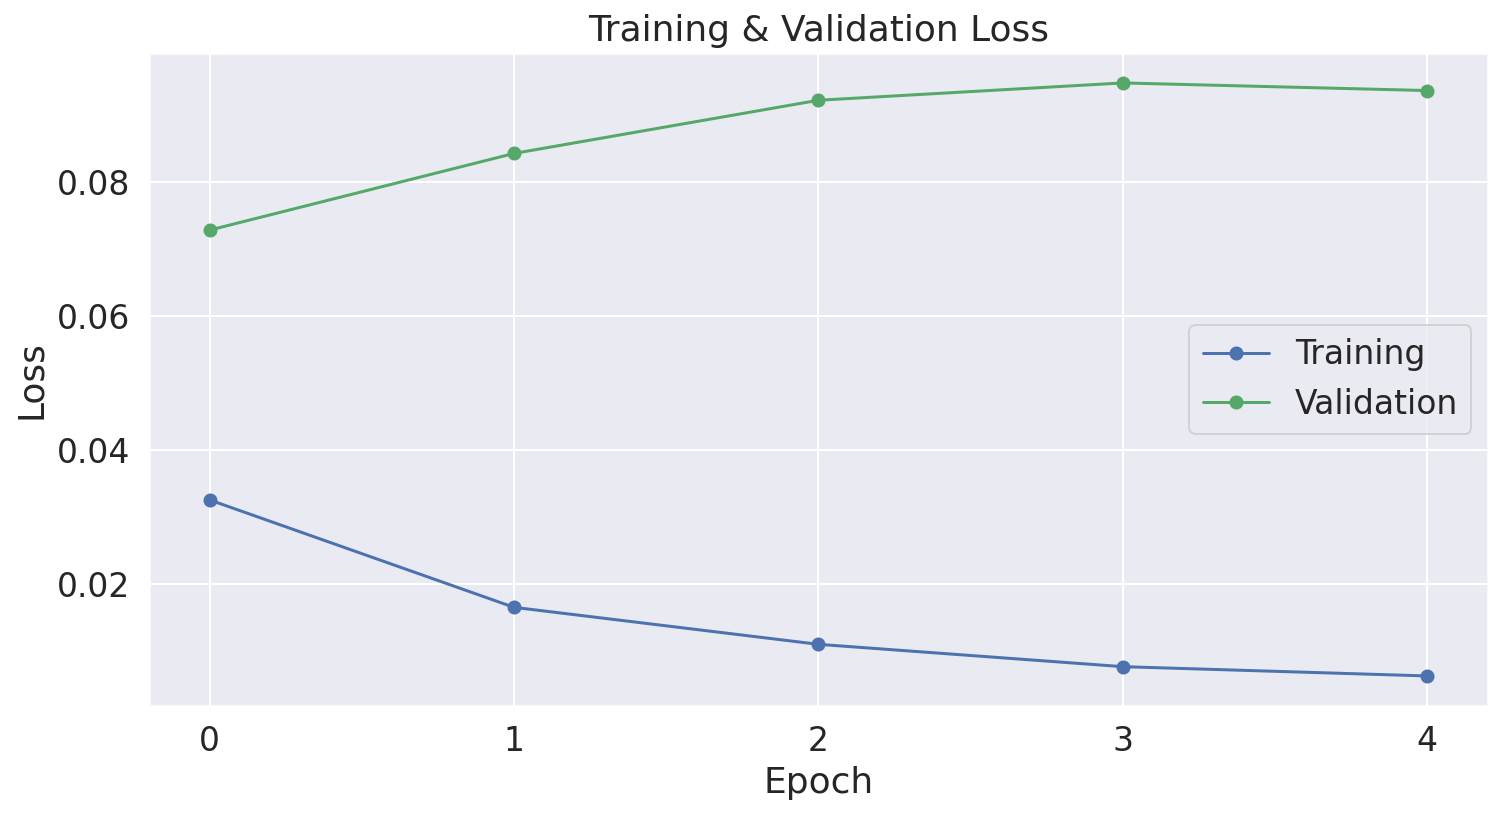

In [30]:
#Visualization train&valid loss
import seaborn as sns

sns.set(style = 'darkgrid')

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12, 6)

#plot learning curve
plt.plot(df_stats['training_loss'], 'b-o', label = 'Training')
plt.plot(df_stats['valid_loss'], 'g-o', label = 'Validation')

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(epochs)))

plt.show()

Text(0.5, 1.0, 'Train & Validation Accuracy over all epochs ')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average accuracy')

([<matplotlib.axis.XTick at 0x7f4a11877210>,
 <a list of 5 Text major ticklabel objects>)

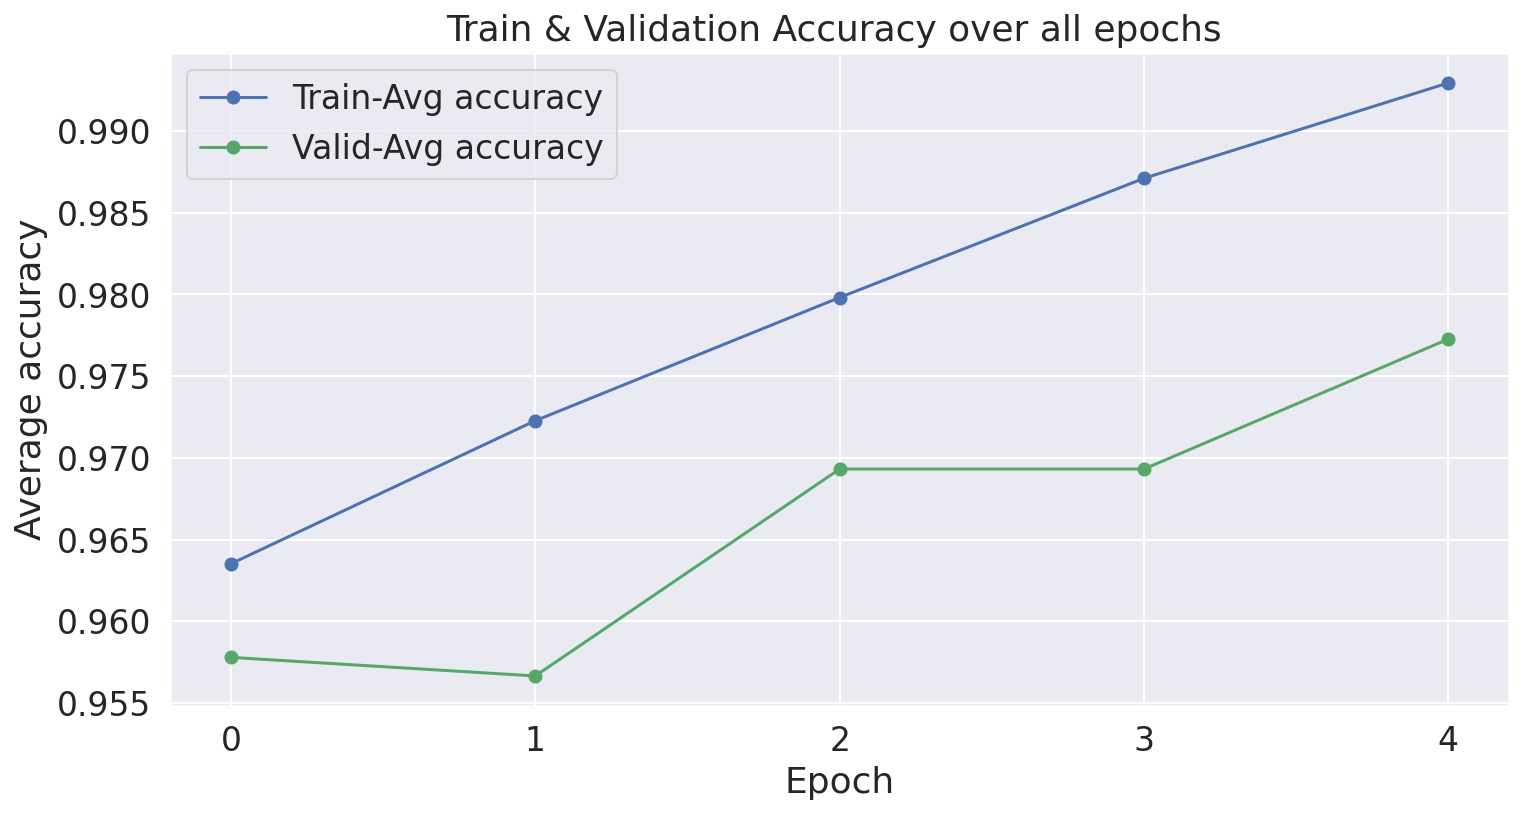

In [34]:
#Visualization accuracy

plt.plot(df_stats['training_acc'], 'b-o', label = 'Train-Avg accuracy')
plt.plot(df_stats['valid_acc'], 'g-o', label = 'Valid-Avg accuracy')

plt.title("Train & Validation Accuracy over all epochs ")
plt.xlabel("Epoch")
plt.ylabel("Average accuracy")
plt.legend()
plt.xticks(list(range(epochs)))

plt.show()